In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
sns.set(style='whitegrid')

# Function to generate Geometric Brownian Motion for crop yields
def GeometricBrownianMotion(S0, mu, sigma, T, N, seed=None):
    '''
    Generate a Geometric Brownian Motion (GBM) path for crop yields.

    Parameters:
    S0 (float): The initial yield (starting point).
    mu (float): The drift term, representing the average growth rate.
    sigma (float): The volatility term, representing the standard deviation of the log returns.
    T (int): The total number of time periods (typically years in the context of this dataset).
    N (int): The number of time steps for the simulation (typically equals T).
    seed (int, optional): The random seed for reproducibility. Defaults to None.

    Returns:
    t (numpy array): An array of time points over the simulation period.
    S (numpy array): The corresponding simulated yield values following GBM.
    
    Geometric Brownian Motion follows the stochastic differential equation:
    dS = mu * S * dt + sigma * S * dW,
    where dW is a Wiener process (Brownian motion), ensuring positive yield values.
    '''
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility
    dt = T / N  # Time step
    t = np.linspace(0, T, N)  # Time points
    W = np.random.randn(N)  # Standard normal random variables
    W = np.cumsum(W) * np.sqrt(dt)  # Brownian motion path
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W  # Drift and volatility term
    S = S0 * np.exp(X)  # Apply exponential to ensure positive values
    return t, S

# Function to generate Standard Brownian Motion for crop yields
def StandardBrownianMotion(S0, mu, sigma, T, N, seed=None):
    '''
    Generate a Standard Brownian Motion (BM) path for crop yields.

    Parameters:
    S0 (float): The initial yield (starting point).
    mu (float): The drift term, representing the average growth rate.
    sigma (float): The volatility term, representing the standard deviation of the yield values.
    T (int): The total number of time periods (typically years in the context of this dataset).
    N (int): The number of time steps for the simulation (typically equals T).
    seed (int, optional): The random seed for reproducibility. Defaults to None.

    Returns:
    t (numpy array): An array of time points over the simulation period.
    S (numpy array): The corresponding simulated yield values following BM.
    
    Standard Brownian Motion follows the stochastic differential equation:
    dS = mu * dt + sigma * dW,
    where dW is a Wiener process (Brownian motion), which can result in both positive and negative yield values.
    '''
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility
    dt = T / N  # Time step
    t = np.linspace(0, T, N)  # Time points
    W = np.random.randn(N)  # Standard normal random variables
    W = np.cumsum(W) * np.sqrt(dt)  # Brownian motion path
    S = S0 + (mu * t) + sigma * W  # Standard Brownian motion
    return t, S

In [4]:
# Load the dataset
file_path = '../datasets/CropSDEData/YIELD_NUTS2_NL_transposed.csv'
transposed_df = pd.read_csv(file_path)

# Get unique regions and crops
regions = transposed_df['IDREGION'].unique()[:3]

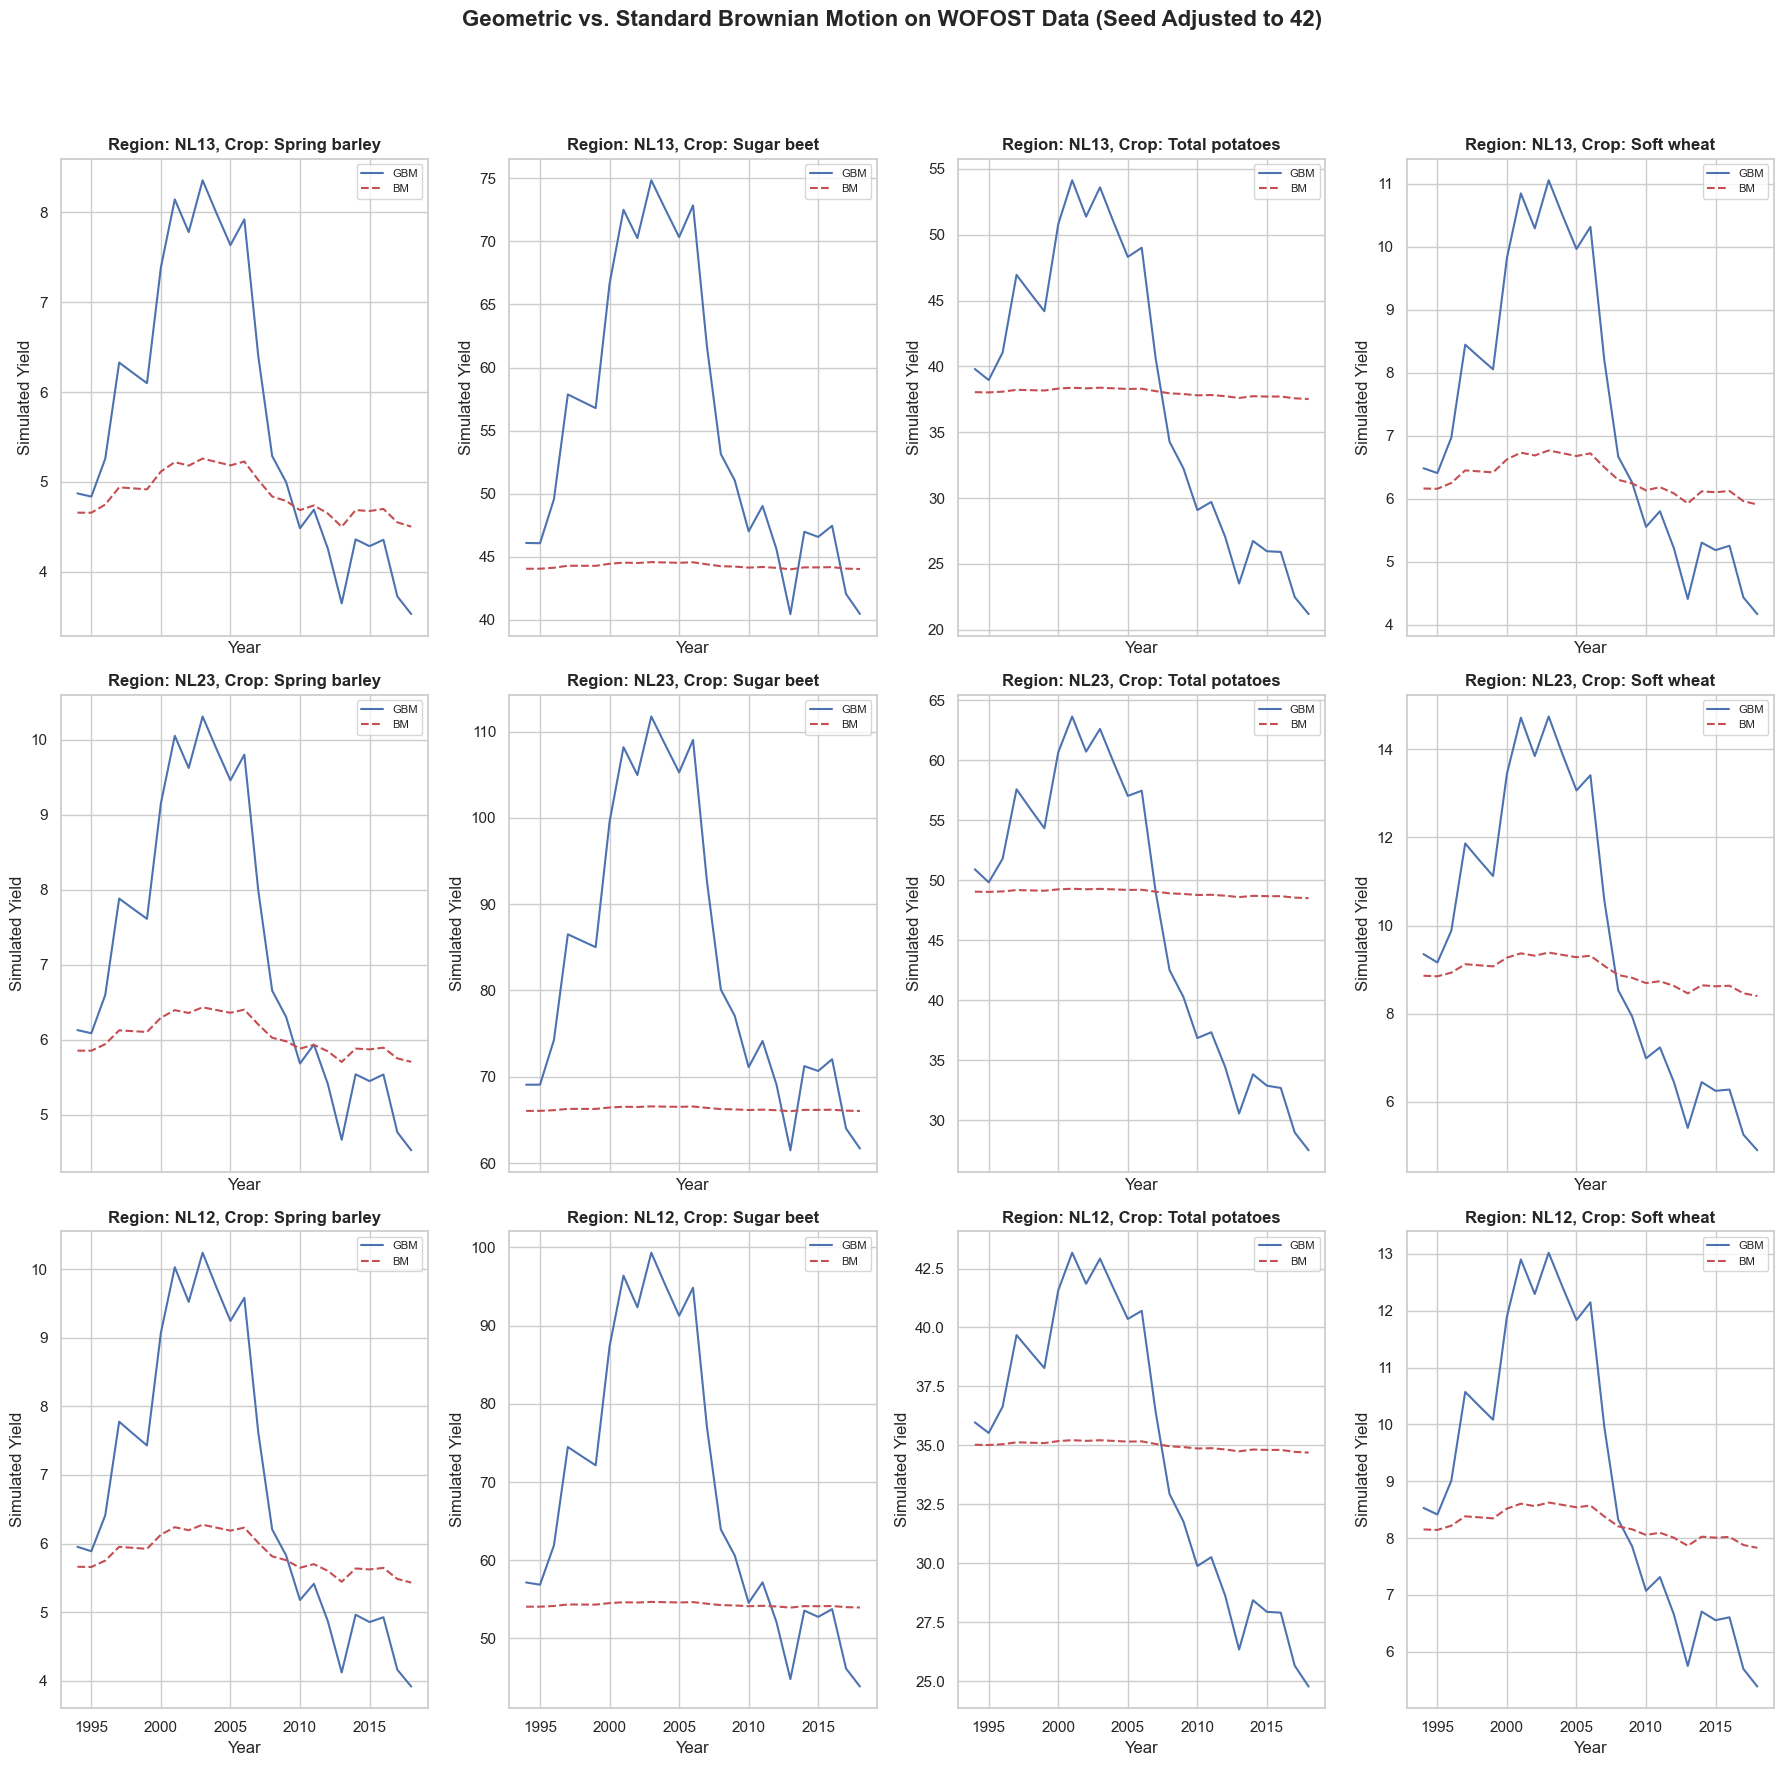

In [5]:
# Create a figure with subplots for each region and crop
num_rows = len(regions)
max_crops_per_region = transposed_df.groupby('IDREGION')['CROP'].nunique().max()
fig, axes = plt.subplots(num_rows, max_crops_per_region, figsize=(18, 6 * num_rows), sharex=True)

# Grand title for the entire figure
plt.suptitle("Geometric vs. Standard Brownian Motion on WOFOST Data (Seed Adjusted to 42)", fontsize=16, weight='bold')

# Loop through each region and plot the GBM and BM for all crops in that region
for i, region_code in enumerate(regions):
    region_data = transposed_df[transposed_df['IDREGION'] == region_code]
    crops_in_region = region_data['CROP'].unique()  # Get crops for the region

    for j, crop_name in enumerate(crops_in_region):
        ax = axes[i, j]  # Select subplot for the region and crop
        crop_data = region_data[region_data['CROP'] == crop_name]

        # Ensure there are enough data points to perform simulations
        if len(crop_data) < 2:
            continue

        # Extract years and yields
        years = crop_data['year'].astype(int).values
        yield_data = crop_data['yield'].values
        S0 = yield_data[0]

        # Estimate parameters for GBM and BM
        log_returns = np.diff(np.log(yield_data))  # Log returns for GBM
        mu = np.mean(log_returns)  # Drift
        sigma = np.std(log_returns)  # Volatility
        T = len(years)
        N = T

        # Generate GBM and BM paths
        t_gbm, S_gbm = GeometricBrownianMotion(S0, mu, sigma, T, N, seed=42)
        t_bm, S_bm = StandardBrownianMotion(S0, mu, sigma, T, N, seed=42)

        # Plot GBM and BM without markers, using only line styles
        ax.plot(years, S_gbm, label='GBM', linestyle='-', color='b')
        ax.plot(years, S_bm, label='BM', linestyle='--', color='r')

        # Set subplot title with bold text
        ax.set_title(f'Region: {region_code}, Crop: {crop_name}', fontsize=12, weight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Simulated Yield')

        # Add legend to each subplot
        ax.legend(loc='best', fontsize=8)

    # Hide extra subplots if a region has fewer crops than the max
    for j in range(len(crops_in_region), max_crops_per_region):
        fig.delaxes(axes[i, j])

plt.tight_layout(rect=[0, 0, 1, 0.94]) 

plt.show()